# ATT&CK Techniques to Security Events

-----------------------------------

* **Author**: Jose Luis Rodriguez - [@Cyb3rPandaH](https://twitter.com/Cyb3rPandaH)
* **Organization**: [Open Threat Research (OTR)](https://github.com/OTRF)
* **References**: 
 - [OSSEM - ATT&CK Event Mapping](https://github.com/OTRF/OSSEM-DM/blob/main/use-cases/mitre_attack/techniques_to_events_mapping.yaml)
 - [Data Sources, Containers, Cloud, and More: What's New in ATT&CK v9?](https://medium.com/mitre-attack/attack-april-2021-release-39accaf23c81)
 - [Defining ATT&CK Data Sources, Part I: Enhancing the Current State](https://medium.com/mitre-attack/defining-attack-data-sources-part-i-4c39e581454f)
 - [Defining ATT&CK Data Sources, Part II: Operationalizing the Methodology](https://medium.com/mitre-attack/defining-attack-data-sources-part-ii-1fc98738ba5b)
 - [ATT&CK - Data Sources Definition](https://github.com/mitre-attack/attack-datasources/tree/main/contribution)

## Importing Python Libraries

In [1]:
# Importing library to manipulate data
import pandas as pd

# Importing library to manipulate yaml data
import yaml
import requests

# Importing library for visualizations
from openhunt import visualizations as vis

## Importing (Sub)Techniques to Security Events Mapping Yaml File

Using the **[attackcti](https://attackcti.com/intro.html)** Python library, we were able to collect all the techniques within the Enterprise matrix. After that, we mapped several security events to each data source/component/relationship. Here is the result:

In [2]:
yamlUrl = 'https://raw.githubusercontent.com/OTRF/OSSEM-DM/main/use-cases/mitre_attack/techniques_to_events_mapping.yaml'
yamlContent = requests.get(yamlUrl)
yamlMapping = yaml.safe_load(yamlContent.text)
mapping = pd.json_normalize(yamlMapping)
mapping.head()

,technique_id,x_mitre_is_subtechnique,technique,tactic,platform,data_source,data_component,name,source,relationship,target,event_id,event_name,event_platform,audit_category,audit_sub_category,log_channel,log_provider
0,T1553.006,True,Code Signing Policy Modification,[defense-evasion],"[Windows, macOS]",windows registry,windows registry key modification,Process modified Windows registry key,process,modified,windows registry key,13,RegistryEvent (Value Set).,Windows,RegistryEvent,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon
1,T1553.006,True,Code Signing Policy Modification,[defense-evasion],"[Windows, macOS]",windows registry,windows registry key modification,Process modified Windows registry key,process,modified,windows registry key,14,RegistryEvent (Key and Value Rename).,Windows,RegistryEvent,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon
2,T1553.006,True,Code Signing Policy Modification,[defense-evasion],"[Windows, macOS]",windows registry,windows registry key modification,Process modified Windows registry key,process,modified,windows registry key,4670,Permissions on an object were changed.,Windows,Object Access,Registry,Security,Microsoft-Windows-Security-Auditing
3,T1553.006,True,Code Signing Policy Modification,[defense-evasion],"[Windows, macOS]",windows registry,windows registry key modification,Process modified Windows registry key,process,modified,windows registry key,DeviceRegistryEvents,DeviceRegistryEvents,Windows,None,NaN,None,Windows Defender Advanced Threat Protection
4,T1553.006,True,Code Signing Policy Modification,[defense-evasion],"[Windows, macOS]",windows registry,windows registry key modification,Process modified Windows registry key value,process,modified,windows registry key value,13,RegistryEvent (Value Set).,Windows,RegistryEvent,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon


### Which are the most relevant data sources for Sub-Technqiues within the Enterprise Matrix?

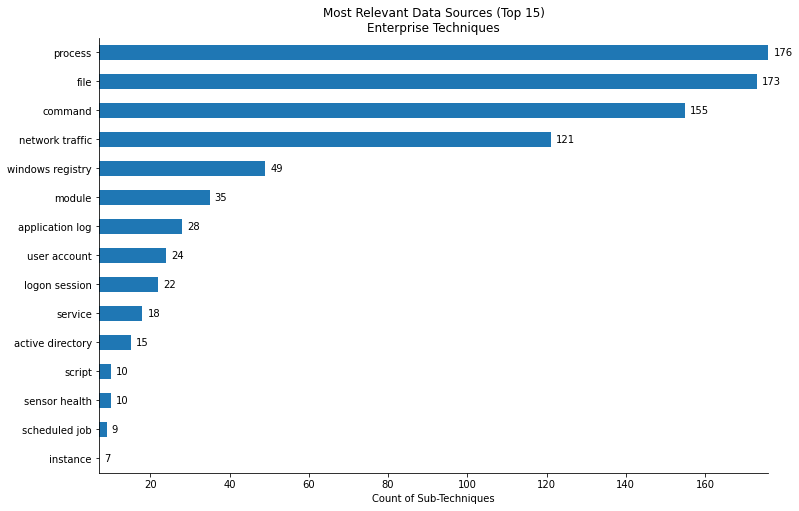

In [3]:
enterprise_sub = mapping[mapping['x_mitre_is_subtechnique'] == True][['technique_id','data_source','data_component']].drop_duplicates()
top15_data_source = enterprise_sub['data_source'].value_counts().nlargest(15).to_frame().reset_index()
title = 'Most Relevant Data Sources (Top 15)\nEnterprise Techniques'
vis.barh_chart(top15_data_source,'data_source','index',title, xlabel = 'Count of Sub-Techniques')

### Which are the most relevant data components for Sub-Technqiues within the Enterprise Matrix?

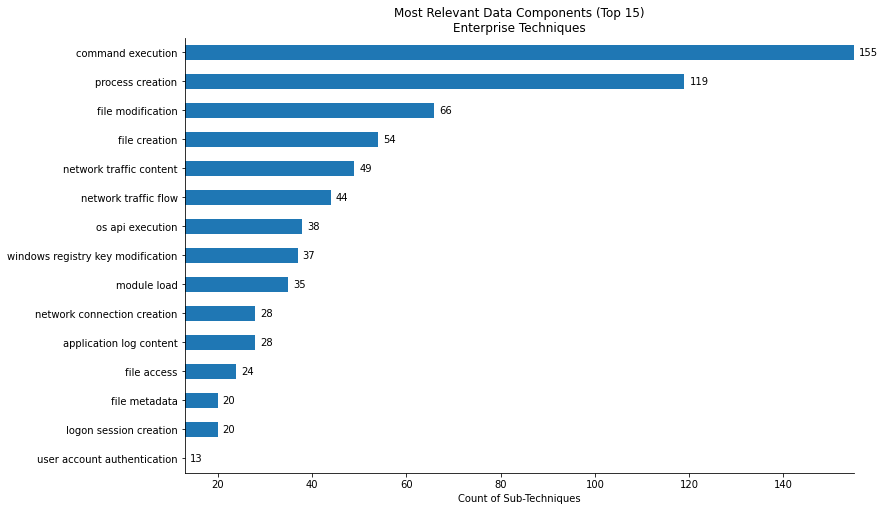

In [4]:
enterprise_sub = mapping[mapping['x_mitre_is_subtechnique'] == True][['technique_id','data_source','data_component']].drop_duplicates()
top15_data_source = enterprise_sub['data_component'].value_counts().nlargest(15).to_frame().reset_index()
title = 'Most Relevant Data Components (Top 15)\nEnterprise Techniques'
vis.barh_chart(top15_data_source,'data_component','index',title, xlabel = 'Count of Sub-Techniques')

## Use Case: OS Credential Dumping: LSASS Memory (T1003.001)

### What are the recommended data sources?

In [5]:
mapping[mapping['technique_id']=='T1003.001'][['data_source', 'data_component']].drop_duplicates()

,data_source,data_component
3383,process,process creation
3389,process,process access
3391,command,command execution
3399,process,os api execution


### What security events can we use to get more context about this technique?

* Network Graph

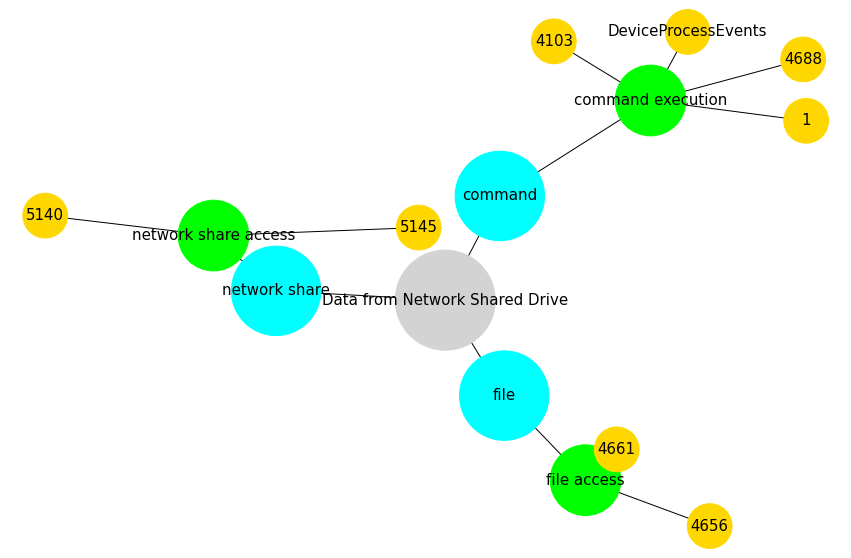

In [10]:
vis.attack_network_graph(mapping[(mapping['technique_id']=='T1039')])

* Table

In [7]:
mapping[mapping['technique_id']=='T1003.001']

,technique_id,x_mitre_is_subtechnique,technique,tactic,platform,data_source,data_component,name,source,relationship,target,event_id,event_name,event_platform,audit_category,audit_sub_category,log_channel,log_provider
3383,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,Process created Process,process,created,process,4688,A new process has been created.,Windows,Detailed Tracking,Process Creation,Security,Microsoft-Windows-Security-Auditing
3384,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,Process created Process,process,created,process,1,Process Creation.,Windows,ProcessCreate,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon
3385,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,Process created Process,process,created,process,DeviceProcessEvents,DeviceProcessEvents,Windows,None,NaN,None,Windows Defender Advanced Threat Protection
3386,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,User created Process,user,created,process,4688,A new process has been created.,Windows,Detailed Tracking,Process Creation,Security,Microsoft-Windows-Security-Auditing
3387,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,User created Process,user,created,process,1,Process Creation.,Windows,ProcessCreate,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon
3388,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process creation,User created Process,user,created,process,DeviceProcessEvents,DeviceProcessEvents,Windows,None,NaN,None,Windows Defender Advanced Threat Protection
3389,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process access,Process accessed Process,process,accessed,process,10,ProcessAccess.,Windows,ProcessAccess,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon
3390,T1003.001,True,LSASS Memory,[credential-access],[Windows],process,process access,Process requested access to Process,process,requested access to,process,4656,A handle to an object was requested.,Windows,Object Access,Kernel Object,Security,Microsoft-Windows-Security-Auditing
3391,T1003.001,True,LSASS Memory,[credential-access],[Windows],command,command execution,Process executed Command,process,executed,command,4688,A new process has been created.,Windows,Detailed Tracking,Process Creation,Security,Microsoft-Windows-Security-Auditing
3392,T1003.001,True,LSASS Memory,[credential-access],[Windows],command,command execution,Process executed Command,process,executed,command,1,Process Creation.,Windows,ProcessCreate,NaN,Microsoft-Windows-Sysmon/Operational,Microsoft-Windows-Sysmon


## This is really cool!!! We have covered all the recommended data sources/components :D
    
## What other security event logs would you recommend for this data source/component? Contribute to the community through OSSEM :D

## You can contribute and map more security events [here](https://github.com/OTRF/OSSEM-DM/tree/main/relationships)